In [25]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from keras.models import load_model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib  
import keras
import os

In [1]:
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import matplotlib
import time

In [2]:
from gp_kernels import *
from gp_priors import *
from gp_plots import *

In [21]:
import numpy as np
from gp_priors import *
from gp_kernels import *

In [3]:
from data_generation import *
from batch_creator import *

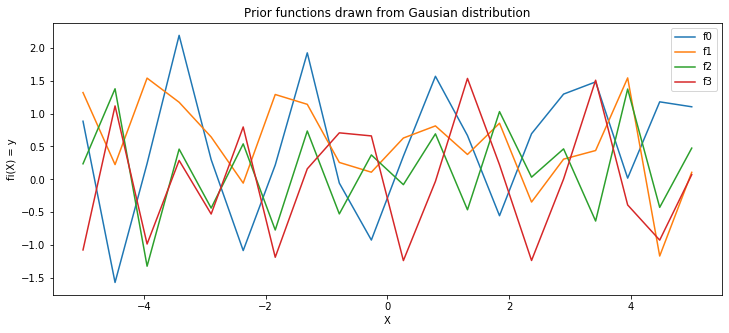

In [4]:
plot_gp_prior(4, n=20)

In [22]:
def data_generator_for_gp_mimick_gpt(num_obs, kernel, tr_percent=0.8):
    '''



    '''
    obs_per_sample = np.random.randint(20, 60, size = num_obs)
    df = np.zeros((num_obs * 2, np.max(obs_per_sample)))
    for i in range(0, num_obs * 2, 2):
        x = np.random.uniform(-5, 5, size=(1, obs_per_sample[int(i / 2)]))
        k = kernel(x)
        f_prior = generate_priors(k, obs_per_sample[int(i / 2)], 1)

        df[i, :x.shape[1]] = x
        df[i + 1, :x.shape[1]] = f_prior

    rows = df.shape[0]
    cols = df.shape[1]
    tr_rows = int(tr_percent * rows)
    tr_rows = tr_rows if tr_rows % 2 == 0 else tr_rows + 1
    df_tr = df[:tr_rows, :]
    df_te = df[tr_rows:, :]

    pad_pos_tr = df_tr[::2, :]
    pad_pos_te = df_te[::2, :]
    pad_y_fren_tr = df_tr[1::2, :]
    pad_y_fren_te = df_te[1::2, :]

    return pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te

In [23]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te = data_generator_for_gp_mimick_gpt(10000, rbf_kernel)

In [ ]:
loss_object = tf.keras.losses.MeanSquaredError()

In [ ]:
optim = tf.keras.optimizers.Adam()

In [ ]:
def loss_function(self, real, pred):
    loss_ = self.loss_object(real, pred)
    return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(self, inp, targ):
    loss = 0

    with tf.GradientTape() as tape:
        pred = model(inp)

        loss += self.loss_function(targ, pred)

    batch_loss = (loss / int(targ.shape[0]))

    variables = self.trainable_variables 

    gradients = tape.gradient(loss, variables)

    self.optim.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [28]:
def create_look_ahead_mask(size):
    '''
    
    
    '''
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    print(tf.shape(mask))
    return mask  # (seq_len, seq_len)

In [31]:
pad_y_fren_tr.shape

(8000, 59)

In [32]:
temp = tf.constant(pad_y_fren_tr, dtype=tf.float32)
create_look_ahead_mask(59)

tf.Tensor([59 59], shape=(2,), dtype=int32)


<tf.Tensor: shape=(59, 59), dtype=float32, numpy=
array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
def create_masks(inp, tar):
    
    
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1]) # if max seq length is 40 -- > this will be 40X40 
    ## this will be batch_size X 1 X 1 X 40
    dec_target_padding_mask = create_padding_mask(tar)
    
    ## This will also be (64, 1, 40, 40)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    ### example output:
    
# bb[60, :, : , 5]
# Out[308]:
# <tf.Tensor: shape=(1, 40), dtype=float32, numpy=
# array([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>
    
    
    return enc_padding_mask, combined_mask, dec_padding_mask

In [26]:
def dot_product_attention(q, k, v, mask):
    '''
    
    '''
    # similarity 
    # q = k = v := (batch_size, max_seq_len, max_seq_len)  
    matmul_qk = tf.nn.relu(tf.matmul(q, k, transpose_b=True)) 
    # matmul_qk is (batch_size, max_seq_len, max_seq_len)

    # -1e9 will turn the softmax output in this locations to zero
    # this is a good mask as an input for softmax -- we need also masking when 
    # want to use matmul as is 
    if mask is not None:
        matmul_qk += (mask * -1e9) 
        
     # turn simialrity to scores
    attention_weights = tf.nn.softmax(matmul_qk, axis=-1)
    
    # weight values 
    # (batch_size, max_seq_len, max_seq_len)
    out_tar = tf.matmul(attention_weights, v)
    
    return out_tar, attention_weights, matmul_qk

In [27]:
def point_wise_feed_forward_network(dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(1)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, pos_d_model, tar_d_model, rate):
        super(Decoder, self).__init__()

        
        self.wq = tf.keras.layers.Dense(pos_d_model)
        self.wk = tf.keras.layers.Dense(pos_d_model)
        self.wv = tf.keras.layers.Dense(pos_d_model)
        
        self.w_att = tf.keras.layers.Dense(d_att)
            
        
        self.hq = tf.keras.layers.Dense(tar_d_model)
        self.hk = tf.keras.layers.Dense(tar_d_model)
        self.hv = tf.keras.layers.Dense(tar_d_model)
        
        self.h_att = tf.keras.layers.Dense(d_att)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(rate)
    
    #a call method, the layer's forward pass
    def call(self, tar_inp, tar_position, training, 
           mask):
               
        
        q_p = self.wq(tar_position) 
        k_p = self.wk(tar_position) 
        
         _, _, pos_attn1 = dot_product_attention(q_p, k_p, k_p)
        # pos_attn1 is (batch_size, max_seq_len, max_seq_len)
        
        q = self.hq(tar_inp) 
        k = self.hk(tar_inp)
        v = self.hv(tar_inp)

        tar_attn1, _, _ = dot_product_attention(q, k, v)
        # tar_attn1 is (batch_size, max_seq_len, max_seq_len)

        #residual layer 
        position = self.layernorm1(self.w_att(pos_attn1) + tar_position)
        
        connector = tf.matmul(position, self.h_att(tar_attn1)) 

        connector = self.dropout(connector, training=training)
        
        out = point_wise_feed_forward_network(connector)
        
        return out

In [ ]:
tf.keras.backend.set_floatx('float32')

In [ ]:
if __name__ == '__main__':
    